In [1]:
from lod.voxel import AggregationMethod
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_dir = "/ssd1/rajrup/Project/livogs_mv/results"
seq_name = "171026_pose3_no_ground"
trained_iter = 10000
trained_voxel_size = 0.001
allowable_voxel_sizes = [0.01, 0.025, 0.05, 0.1]

frame_id = 580

exp_names = [
    f"nogop_voxel_size_{trained_voxel_size}_freeze_means_voxelized_to_voxel_size_{voxel_size}"
    for voxel_size in allowable_voxel_sizes
]

aggregate_methods = [
    AggregationMethod.sum,  # Sum of gaussians
    AggregationMethod.dominant,  # Dominant gaussian
    AggregationMethod.mean,  # Mean of gaussians
    AggregationMethod.kl_moment,  # KL(p||q) first‑/second‑moment match
    AggregationMethod.kl_moment_hybrid_mean_moment,  # KL(p||q) for 1st moment
    AggregationMethod.h3dgs,  # H3DGS aggregation method
    AggregationMethod.h3dgs_hybrid_mean_moment,  # H3DGS for 1st moment
    AggregationMethod.w2,  # Wasserstein-2 distance aggregation method
    AggregationMethod.w2_h3dgs,
    AggregationMethod.scales_voxel_width,  # Scales equal to voxel size
]

aggregate_methods_rename = [
    "Weighted Sum",
    "Dominant (Mode Seeking)",
    "Mean",
    "KL (Mass Covering)",
    "Mean & color weighted by opacity",
    "H3DGS",
    "Mean & color weighted by area",
    "Wasserstein-2",
    "Wasserstein-2 + H3DGS",
    "Scales = voxel size",
]

In [3]:
result_dict = {}
for voxel_size, exp_name in zip(allowable_voxel_sizes, exp_names):
    result_dict[voxel_size] = {}
    for aggregate_method in aggregate_methods:
        result_dir = os.path.join(
            data_dir, exp_name, seq_name, f"{frame_id}", f"{aggregate_method}"
        )

        result_dict[voxel_size][aggregate_method] = {
            "step": [],
            "psnr": [],
            "ssim": [],
            "lpips": [],
            "time": {},
        }

        for step in range(0, trained_iter, 1000):
            if step == 0:
                path = os.path.join(result_dir, "stats", f"val_step{step:04d}.json")
            else:
                path = os.path.join(result_dir, "stats", f"val_step{step-1:04d}.json")
            with open(path, "r") as f:
                data = json.load(f)

            result_dict[voxel_size][aggregate_method]["step"].append(step)
            result_dict[voxel_size][aggregate_method]["psnr"].append(data["psnr"])
            result_dict[voxel_size][aggregate_method]["ssim"].append(data["ssim"])
            result_dict[voxel_size][aggregate_method]["lpips"].append(data["lpips"])

        path = os.path.join(result_dir, "voxel_stats.json")
        with open(path, "r") as f:
            data = json.load(f)

        result_dict[voxel_size][aggregate_method]["time"] = data

In [4]:
result_dict

{0.01: {'sum': {'step': [0,
    1000,
    2000,
    3000,
    4000,
    5000,
    6000,
    7000,
    8000,
    9000],
   'psnr': [32.188106536865234,
    35.13199996948242,
    36.20601272583008,
    37.64748764038086,
    39.31516647338867,
    39.75155258178711,
    40.02481460571289,
    40.252254486083984,
    40.44839096069336,
    40.59054183959961],
   'ssim': [0.986423134803772,
    0.99123615026474,
    0.992181122303009,
    0.9938021898269653,
    0.9956173896789551,
    0.9958053827285767,
    0.9959293603897095,
    0.9960188865661621,
    0.9960838556289673,
    0.9961326718330383],
   'lpips': [0.05158760026097298,
    0.04882463440299034,
    0.046294163912534714,
    0.0429033525288105,
    0.042152103036642075,
    0.04176490008831024,
    0.0415341854095459,
    0.04127198085188866,
    0.04113953933119774,
    0.04096868634223938],
   'time': {'voxel_creation': 1343.137502670288,
    'attribute_aggregation': 2104.57706451416,
    'model_creation': 177.5405406951904

In [5]:
exp_names = [
    f"nogop_voxel_size_{voxel_size}_freeze_means"
    for voxel_size in allowable_voxel_sizes
]
upperbound_quality_dict = {}
for voxel_size, exp_name in zip(allowable_voxel_sizes, exp_names):
    upperbound_quality_dict[voxel_size] = {
        "psnr": 0.0,
        "ssim": 0.0,
        "lpips": 0.0,
    }
    result_dir = os.path.join(data_dir, exp_name, seq_name, f"{frame_id}")
    path = os.path.join(result_dir, "stats", f"val_step{trained_iter-1:04d}.json")
    with open(path, "r") as f:
        data = json.load(f)
    upperbound_quality_dict[voxel_size]["psnr"] = data["psnr"]
    upperbound_quality_dict[voxel_size]["ssim"] = data["ssim"]
    upperbound_quality_dict[voxel_size]["lpips"] = data["lpips"]

In [6]:
upperbound_quality_dict

{0.01: {'psnr': 39.39711380004883,
  'ssim': 0.9957149624824524,
  'lpips': 0.03945155069231987},
 0.025: {'psnr': 34.245235443115234,
  'ssim': 0.9902920126914978,
  'lpips': 0.054761726409196854},
 0.05: {'psnr': 31.22999382019043,
  'ssim': 0.9814727902412415,
  'lpips': 0.08608061075210571},
 0.1: {'psnr': 28.909936904907227,
  'ssim': 0.9733778238296509,
  'lpips': 0.12188418954610825}}

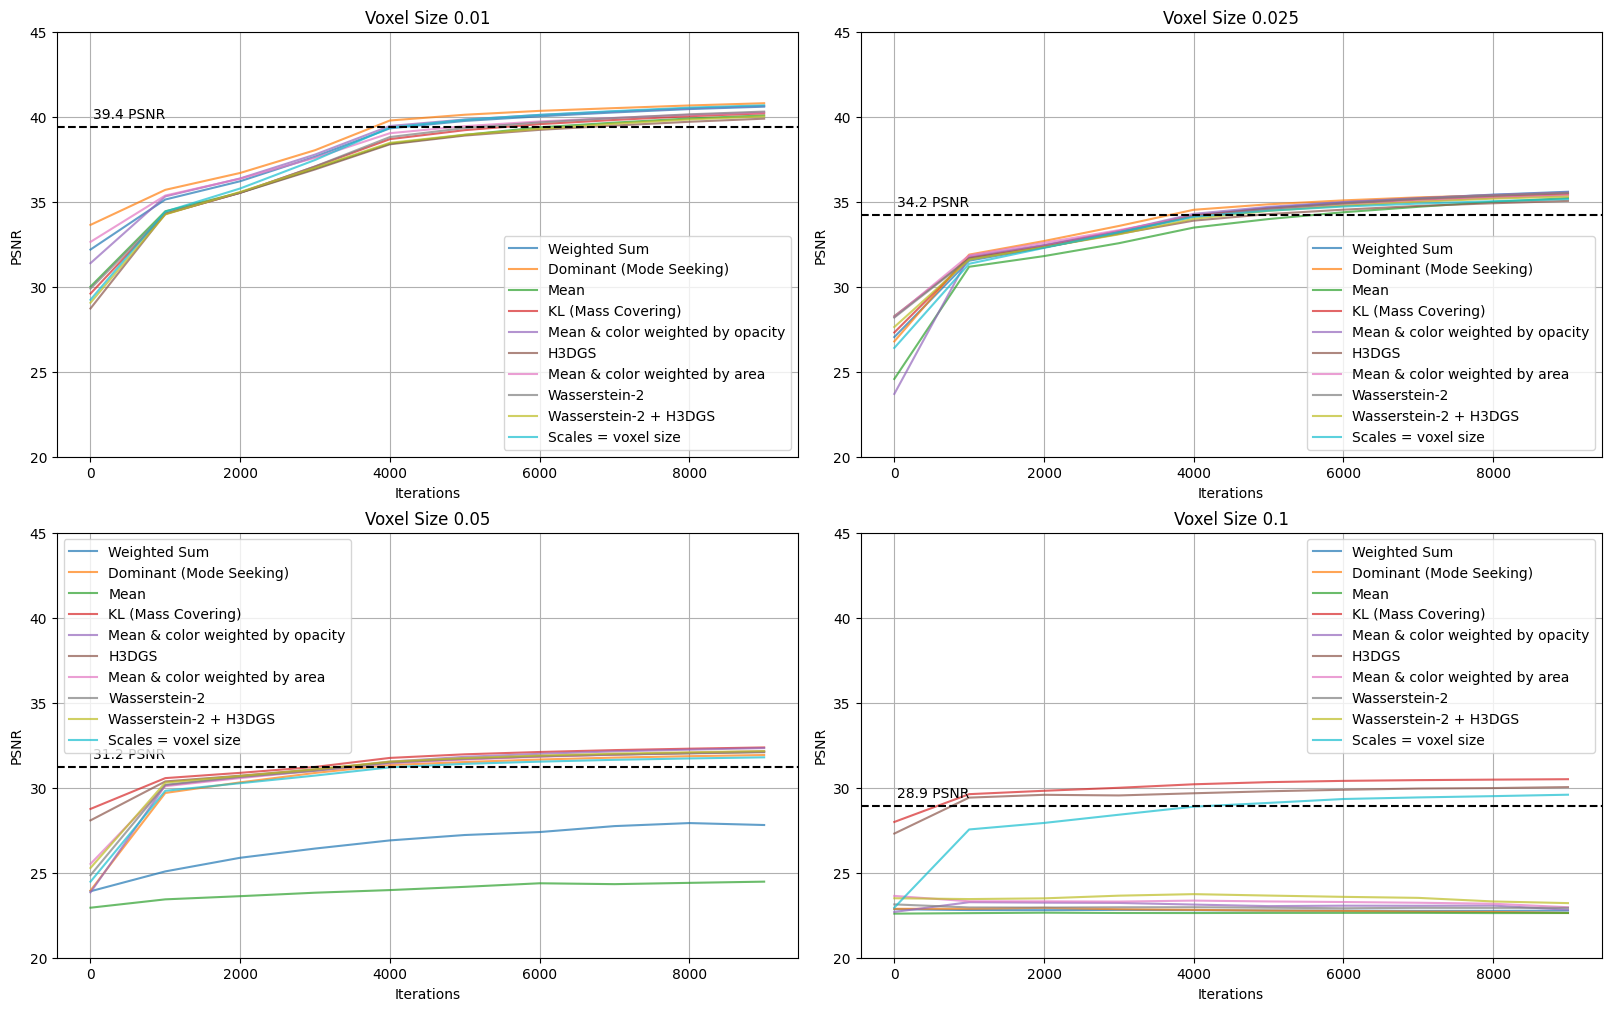

In [7]:
# Create figure with subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
metrics = ["psnr"]
metric_names = ["PSNR"]
# colors = ["blue", "red"]  # One color for each threshold

for i, voxel_size in enumerate(allowable_voxel_sizes):
    if i < 2:
        ax = axes[0, i]
    else:
        ax = axes[1, i - 2]
    for metric, metric_name in zip(metrics, metric_names):
        for method, method_name in zip(aggregate_methods, aggregate_methods_rename):
            # Plot for each frame
            steps = result_dict[voxel_size][method]["step"]
            values = result_dict[voxel_size][method][metric]
            ax.plot(
                steps,
                values,
                alpha=0.7,
                label=f"{method_name}",
            )

        ax.set_xlabel("Iterations")
        ax.set_ylabel(metric_name)
        ax.grid(True)
        ax.legend()
        ax.set_title(f"Voxel Size {voxel_size}")
        ax.set_ylim(20, 45)

        # Add upper bound quality
        ax.axhline(
            upperbound_quality_dict[voxel_size][metric],
            color="black",
            linestyle="--",
            label="Upper Bound Quality",
        )
        # Add upper bound quality text
        ax.text(
            1000,
            upperbound_quality_dict[voxel_size][metric] + 0.5,
            f"{upperbound_quality_dict[voxel_size][metric]:.1f} PSNR",
            ha="right",
        )
plt.show()

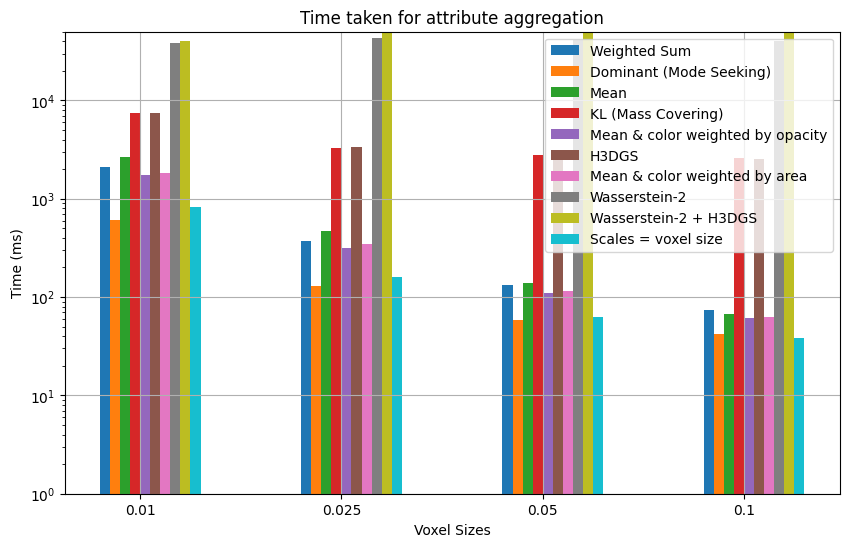

In [9]:
# Create figure with subplots for each metric
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(len(allowable_voxel_sizes))
width = 0.05
for j, (method, method_name) in enumerate(
    zip(aggregate_methods, aggregate_methods_rename)
):
    aggergation_times = []
    for i, voxel_size in enumerate(allowable_voxel_sizes):

        aggergation_time = result_dict[voxel_size][method]["time"][
            "attribute_aggregation"
        ]
        aggergation_times.append(aggergation_time)

    # Bar plot for aggregation time
    ax.bar(
        x + j * width,
        aggergation_times,
        width,
        label=method_name,
    )

    ax.set_xlabel("Voxel Sizes")
    ax.set_ylabel("Time (ms)")
    ax.set_xticks(x + 3.5 * width)
    ax.set_xticklabels(allowable_voxel_sizes)
    ax.grid(True)
    ax.legend()
    ax.set_yscale("log")
    ax.set_title(f"Time taken for attribute aggregation")
    ax.set_ylim(1, 50000)
plt.show()

In [10]:
aggregate_methods[:4]

['sum', 'dominant', 'mean', 'kl_moment']

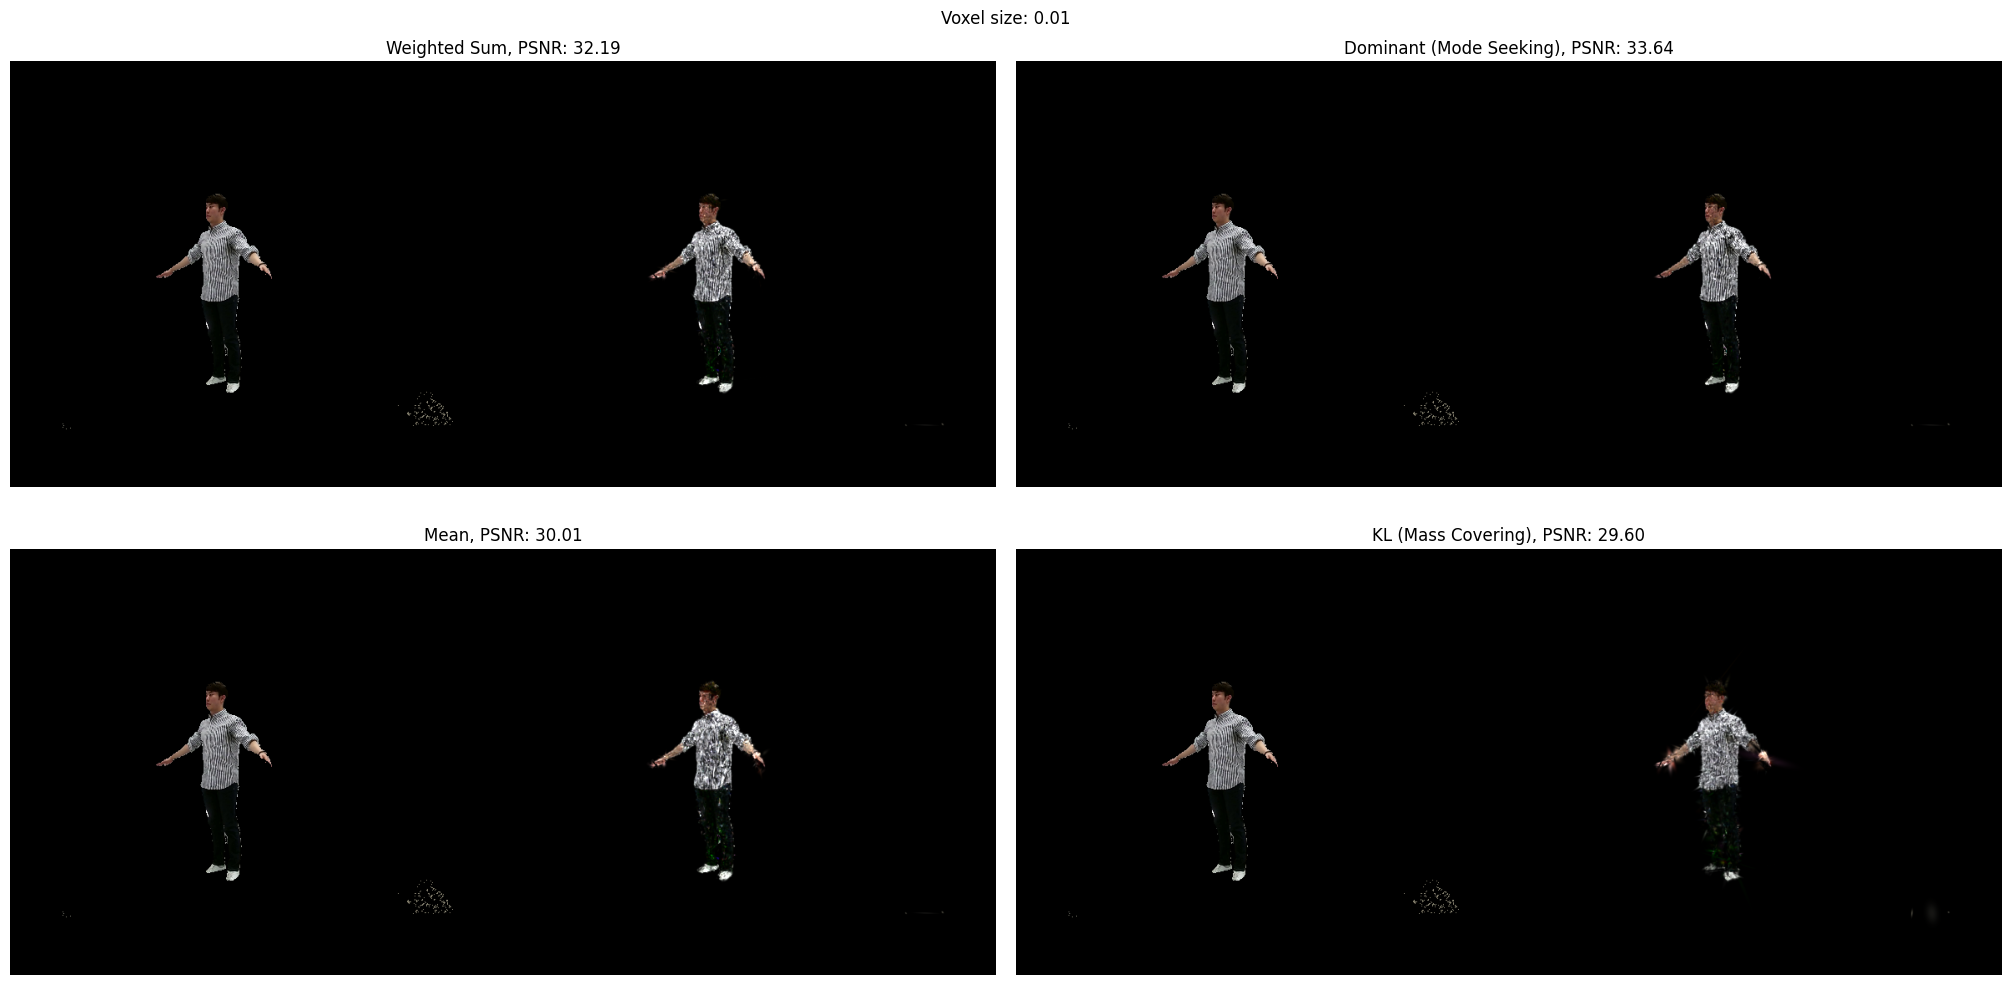

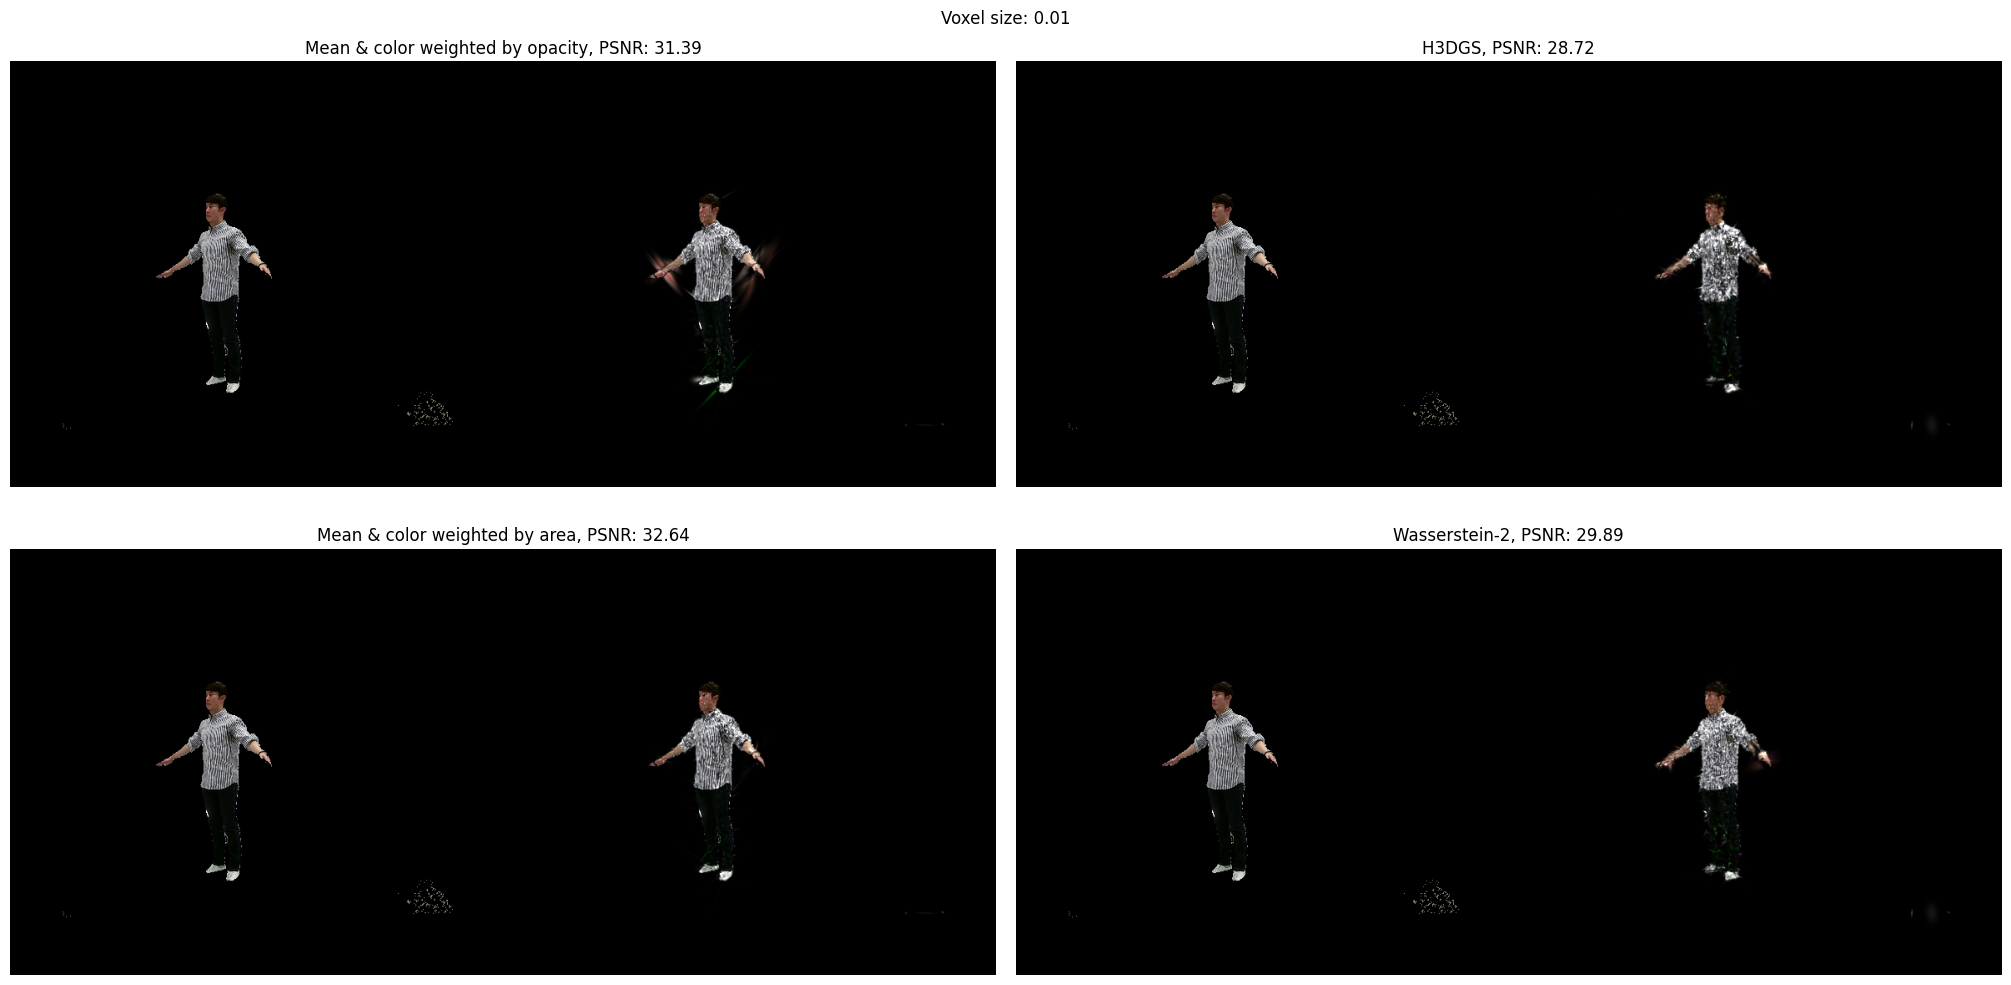

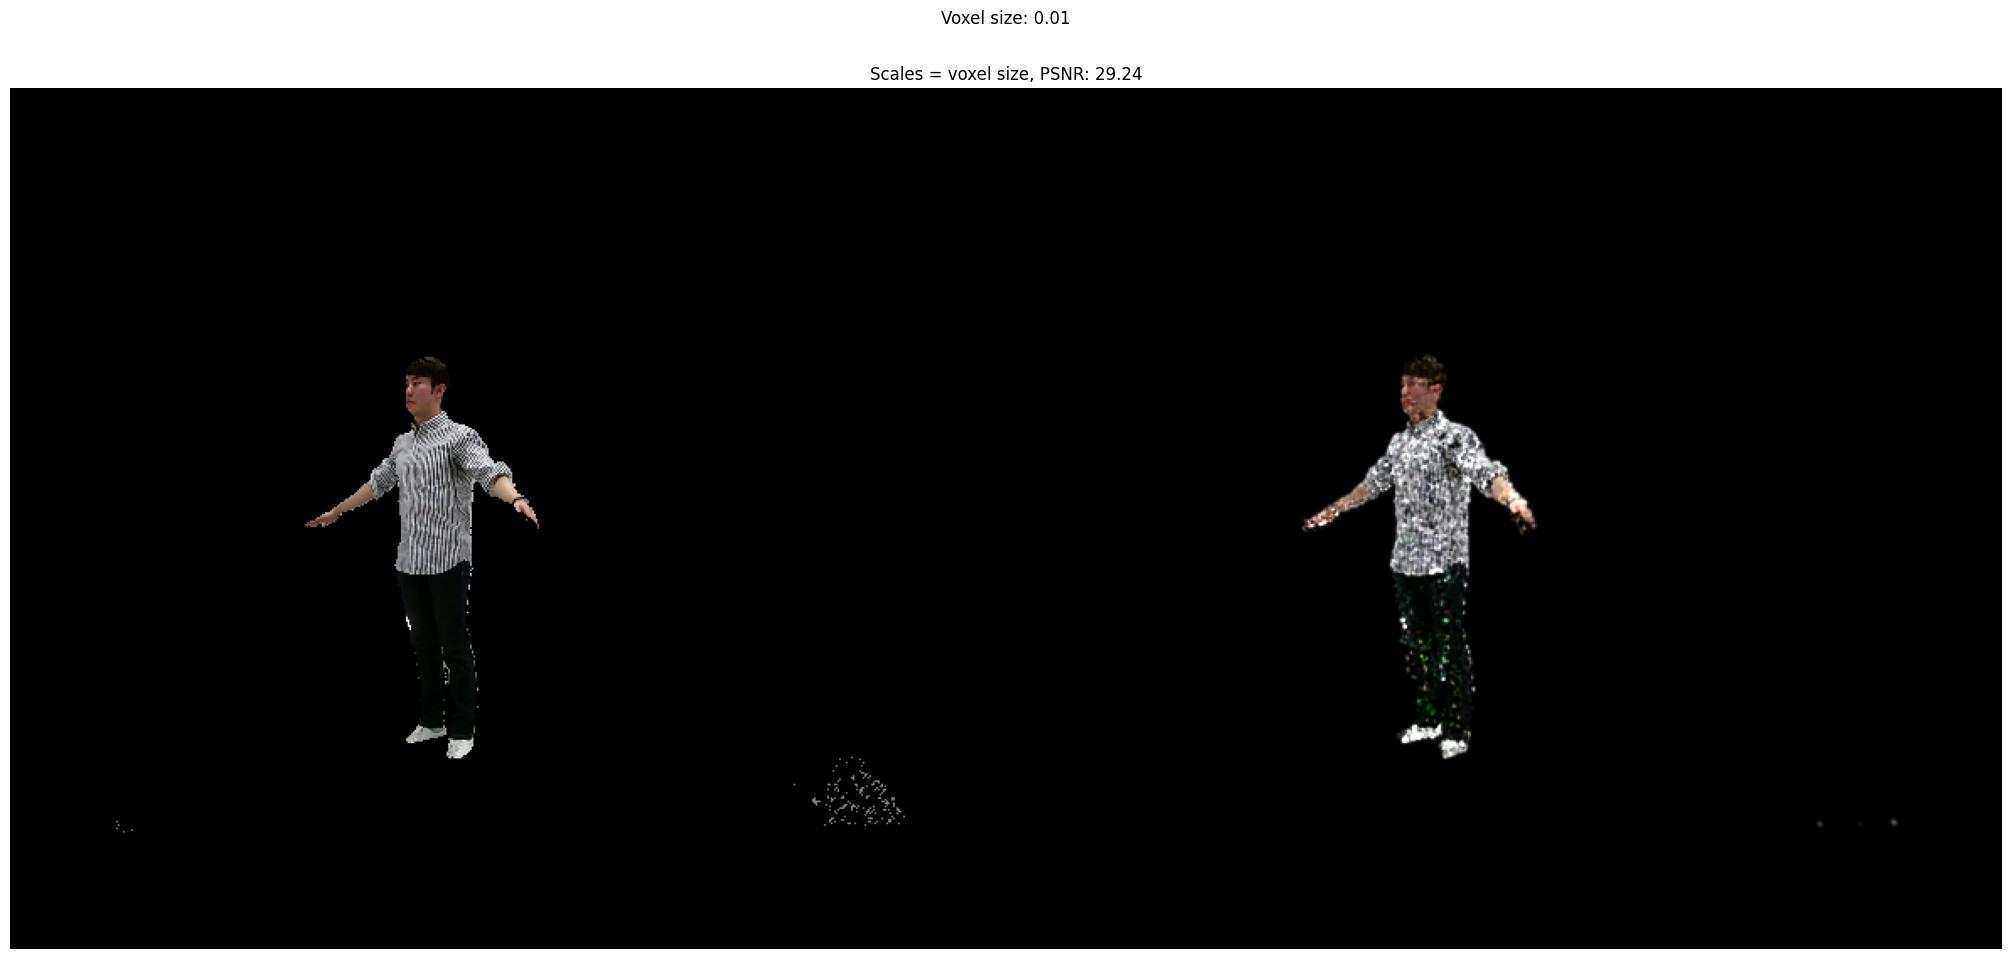

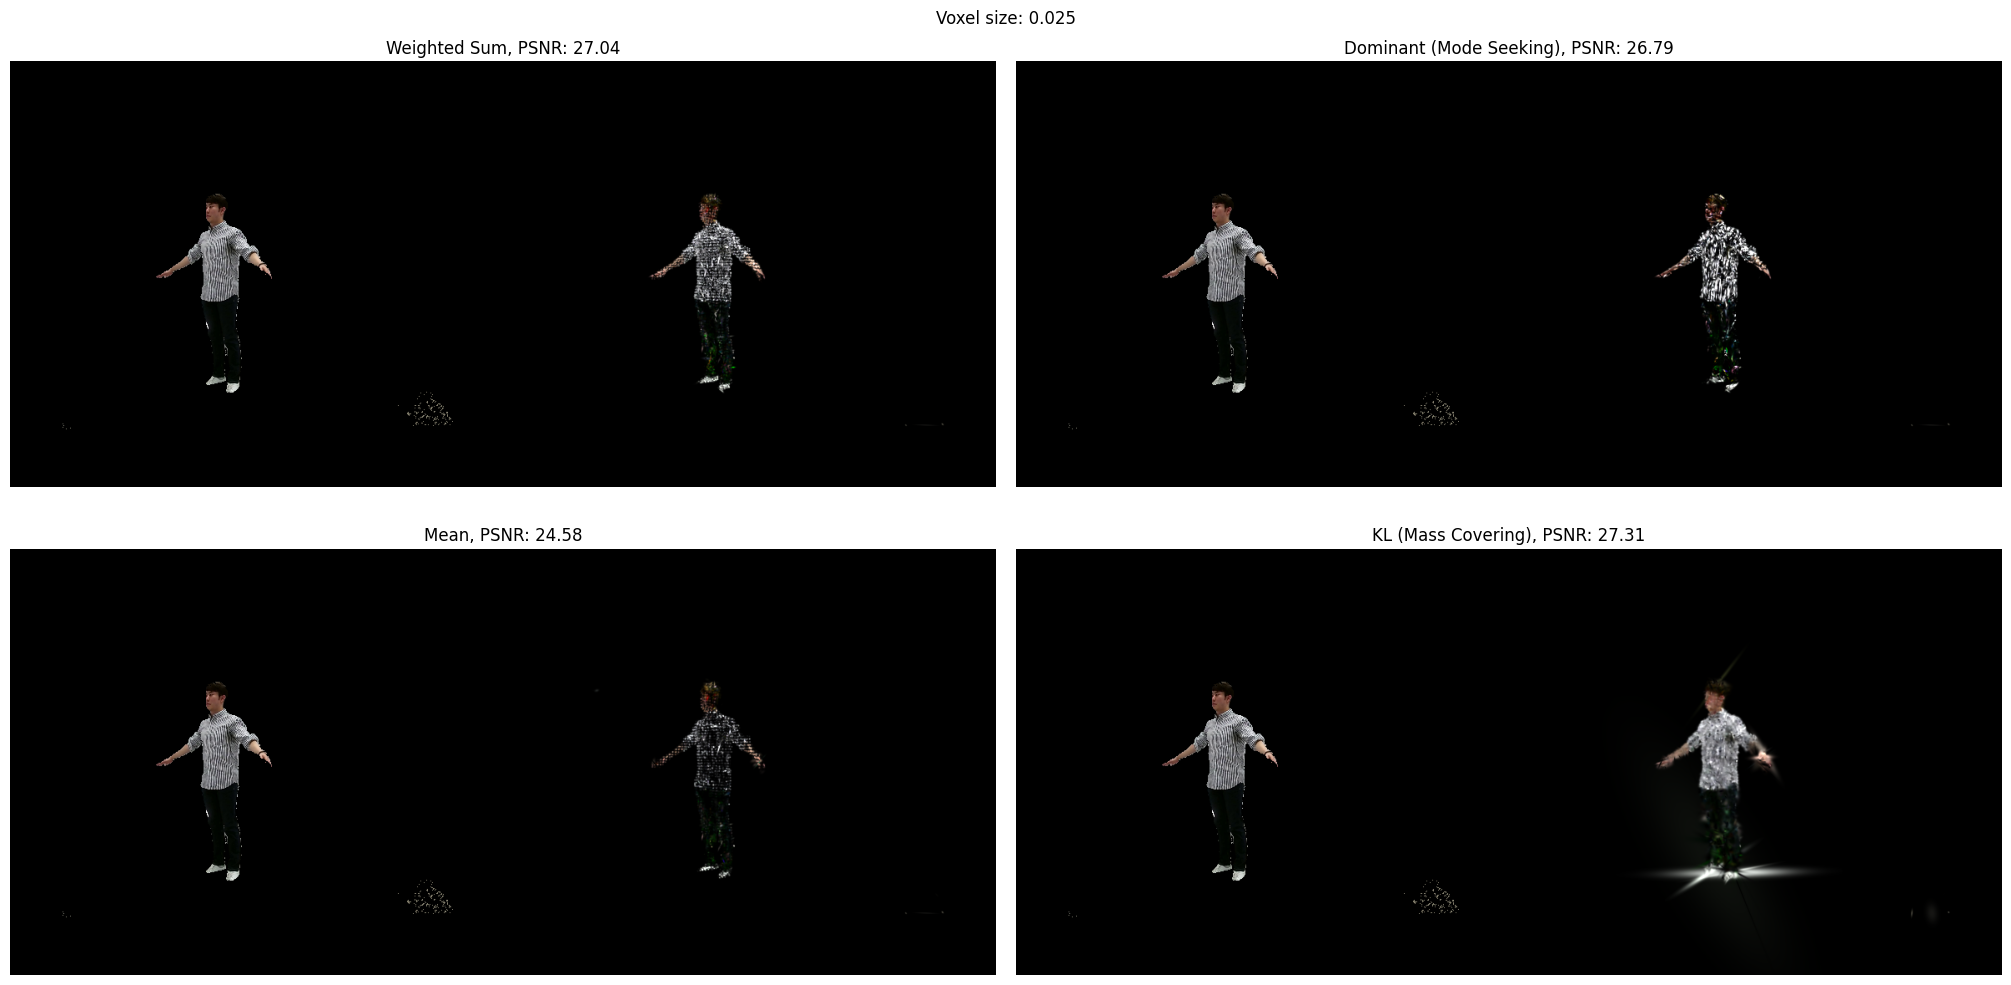

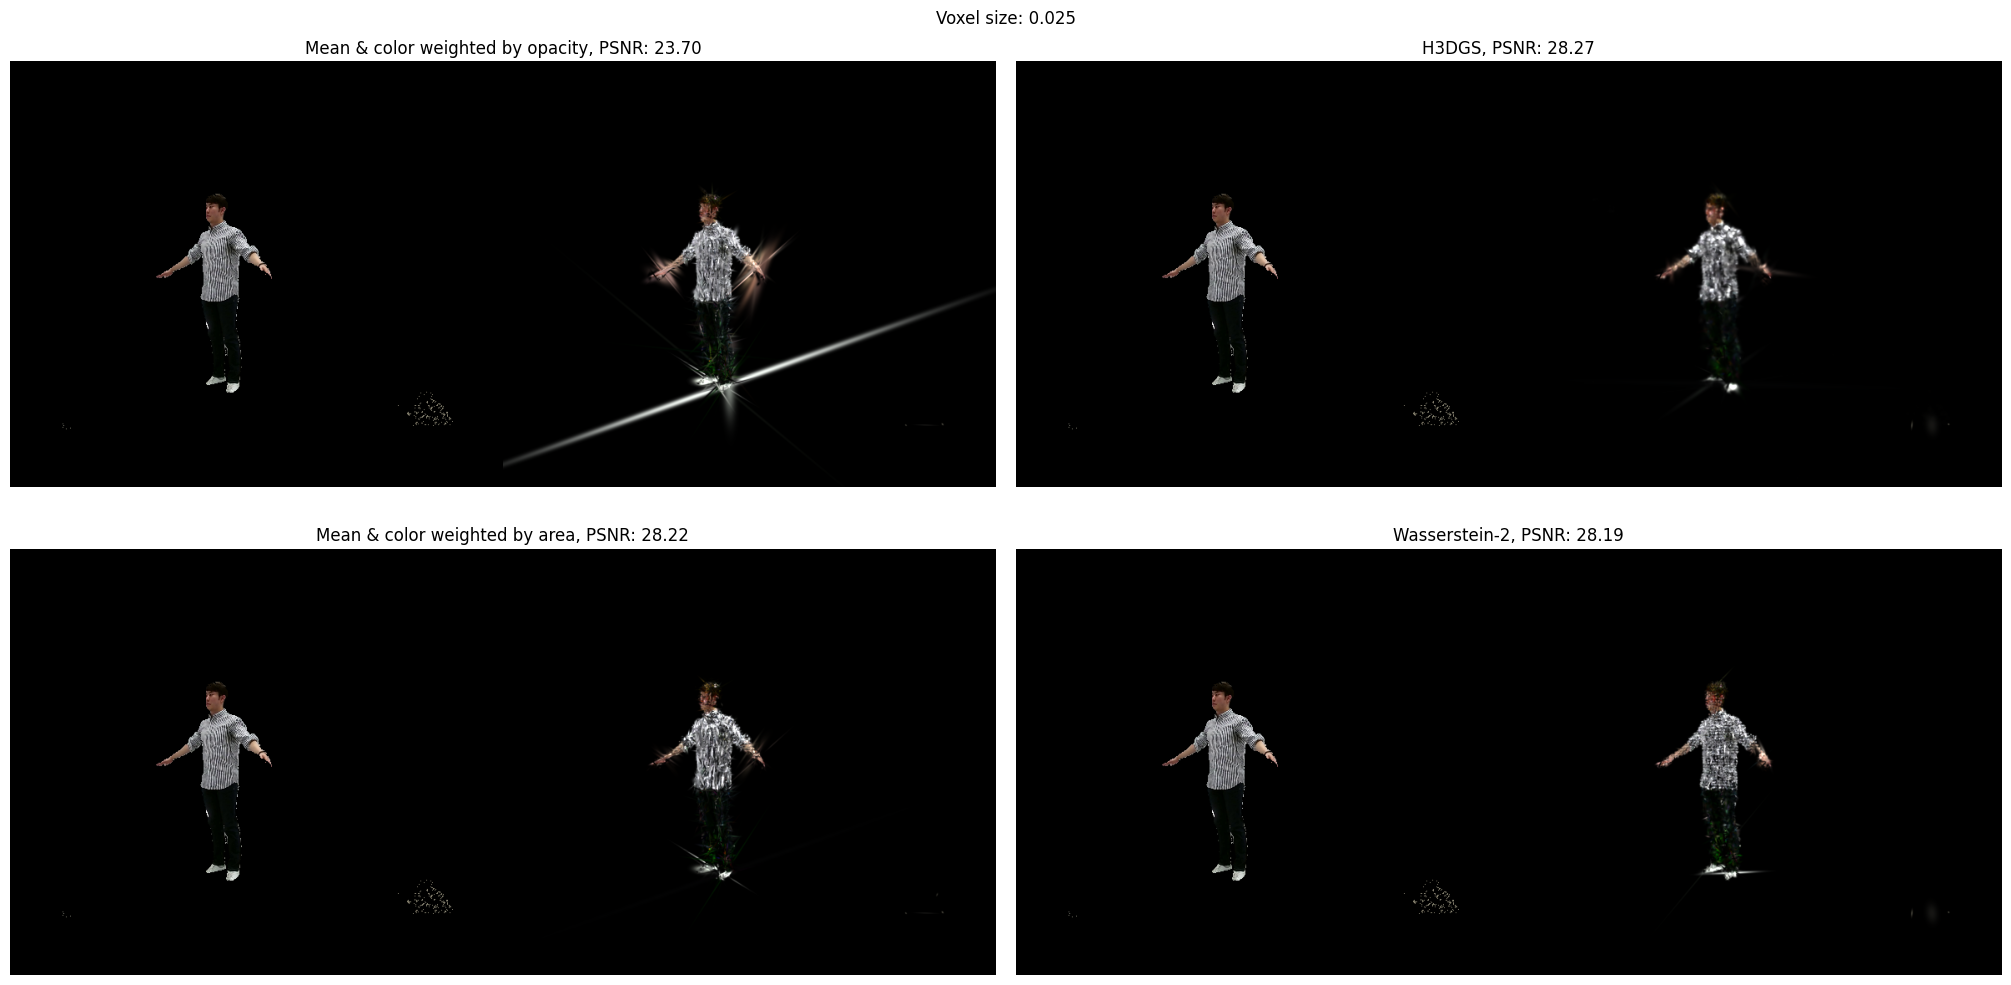

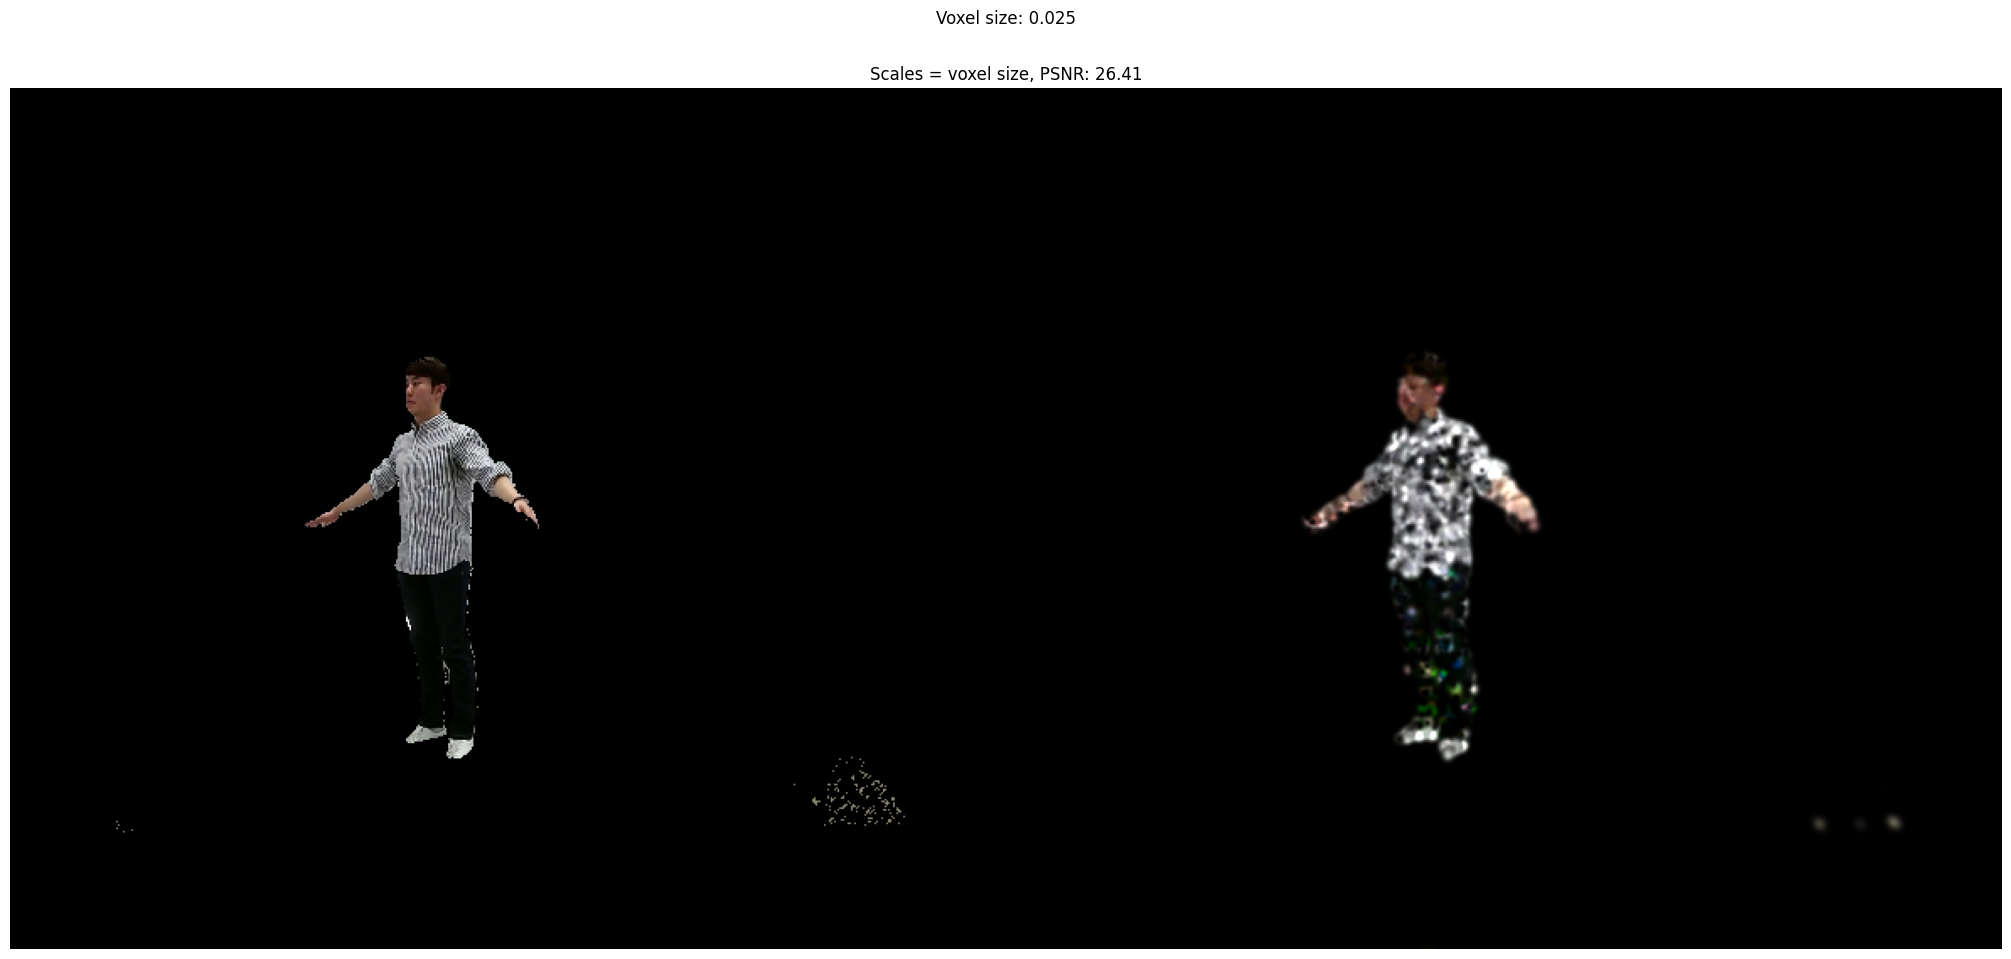

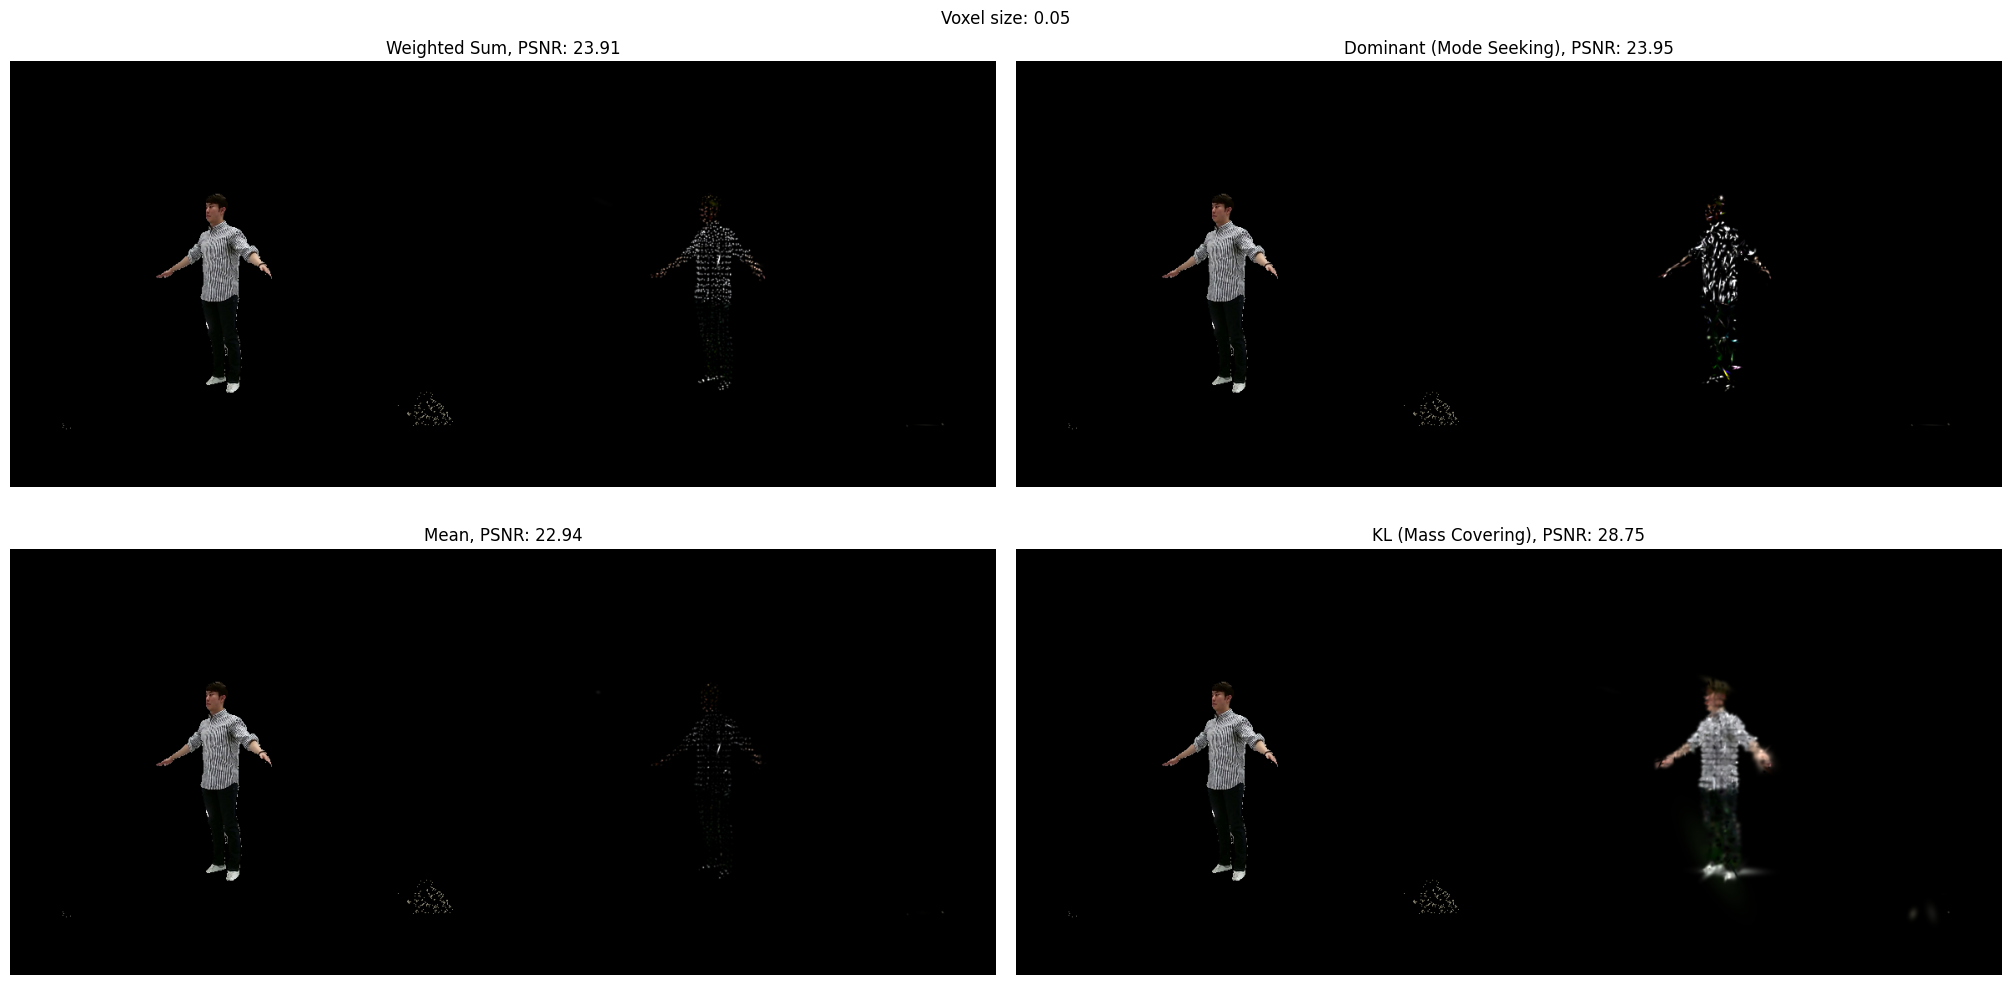

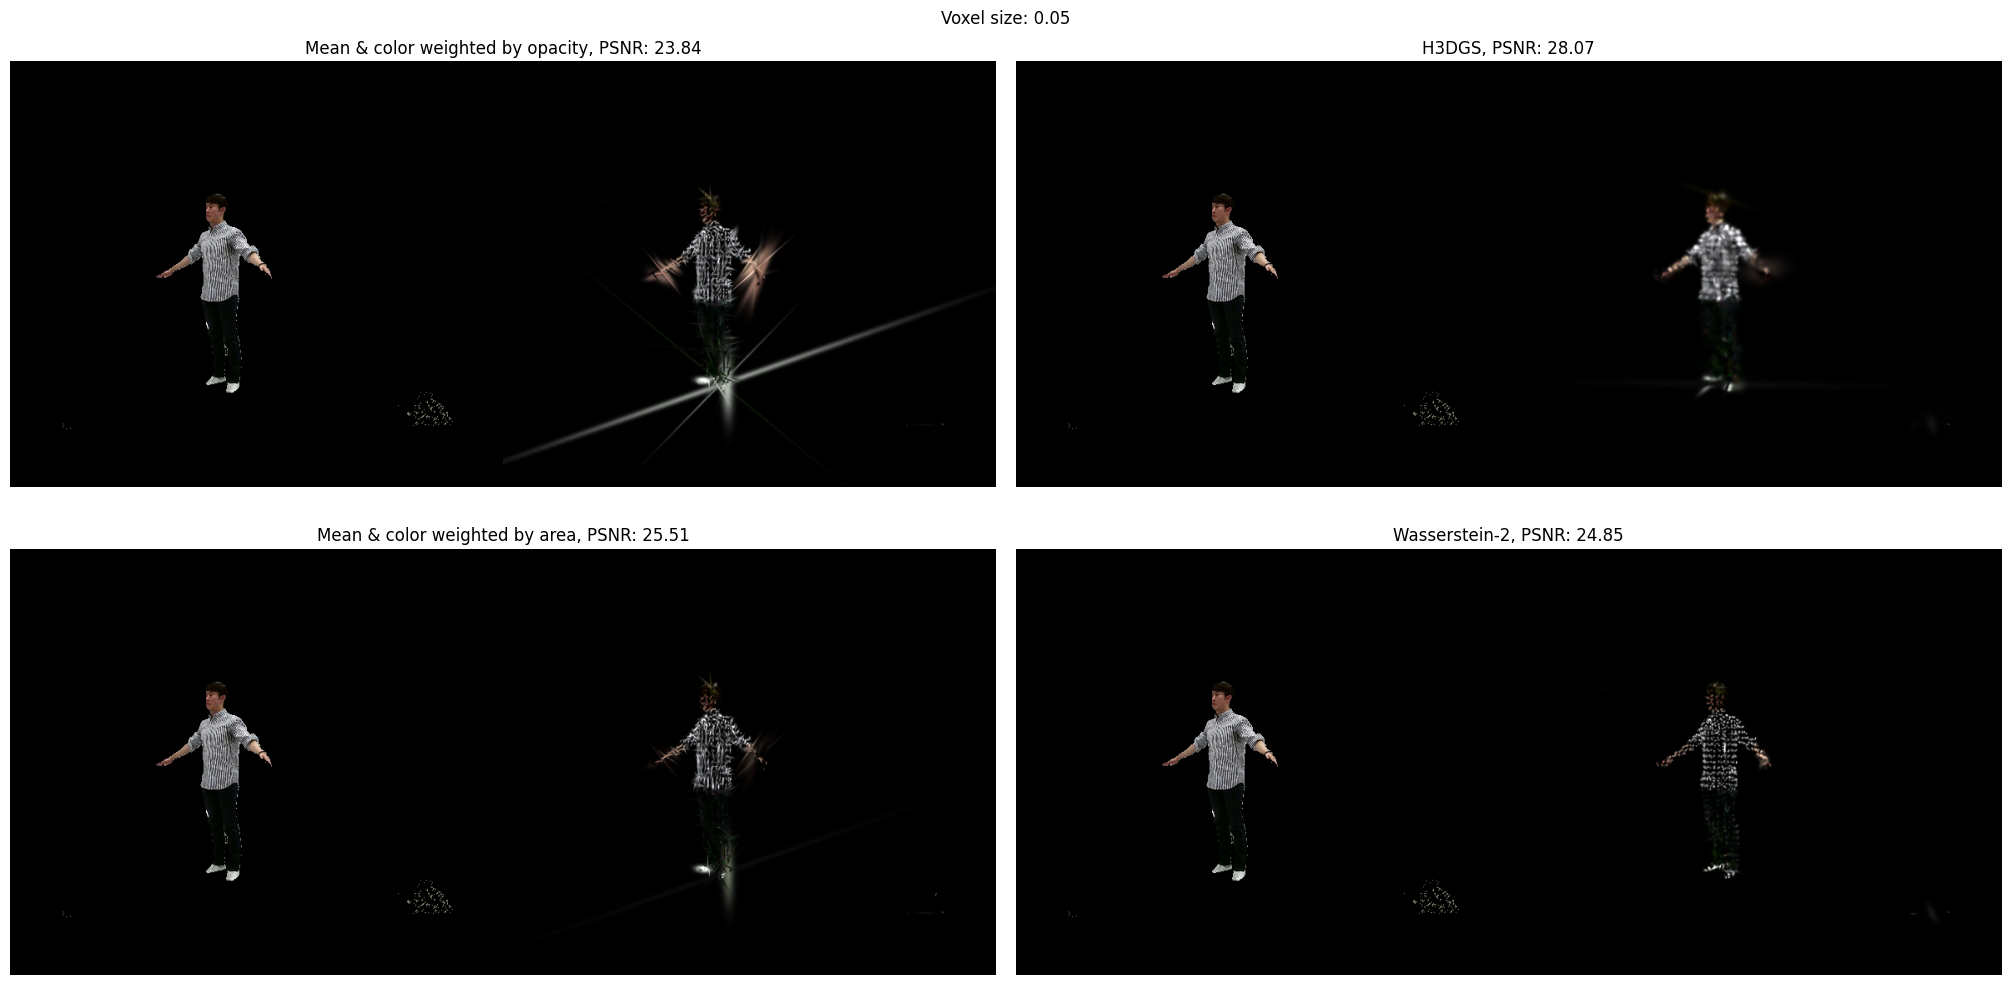

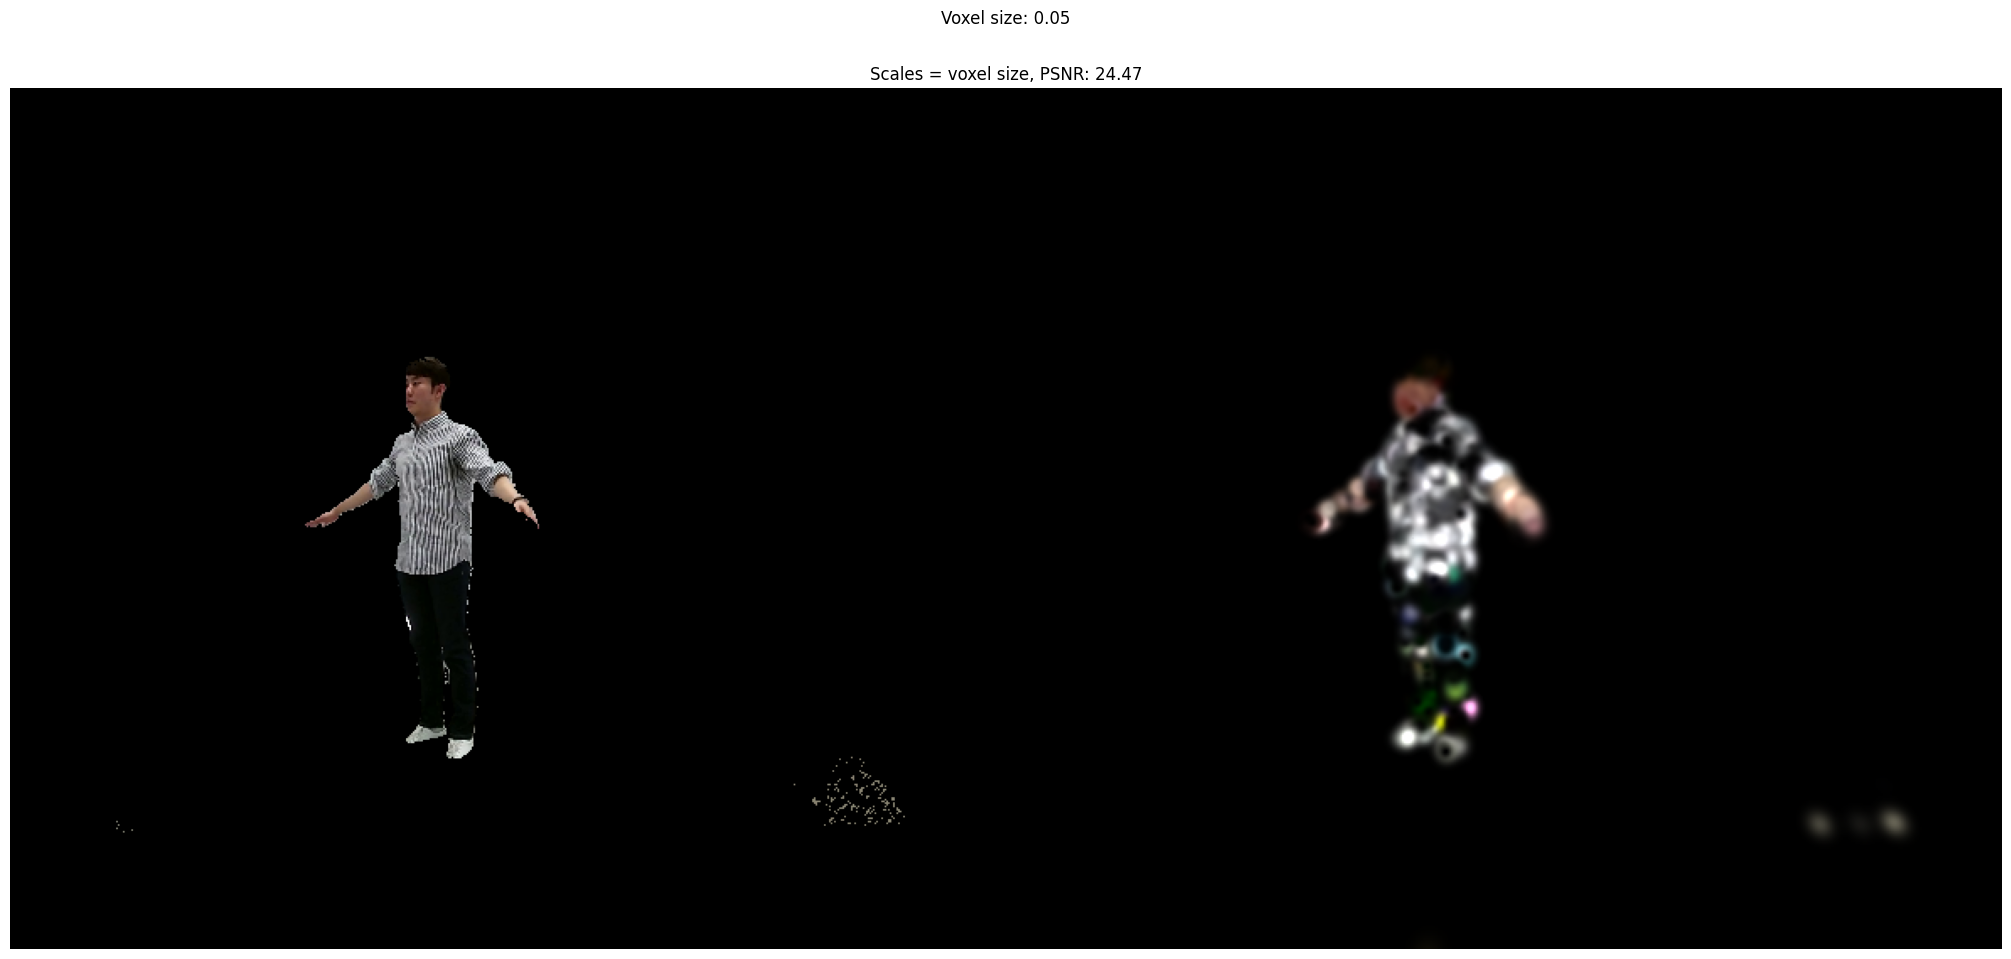

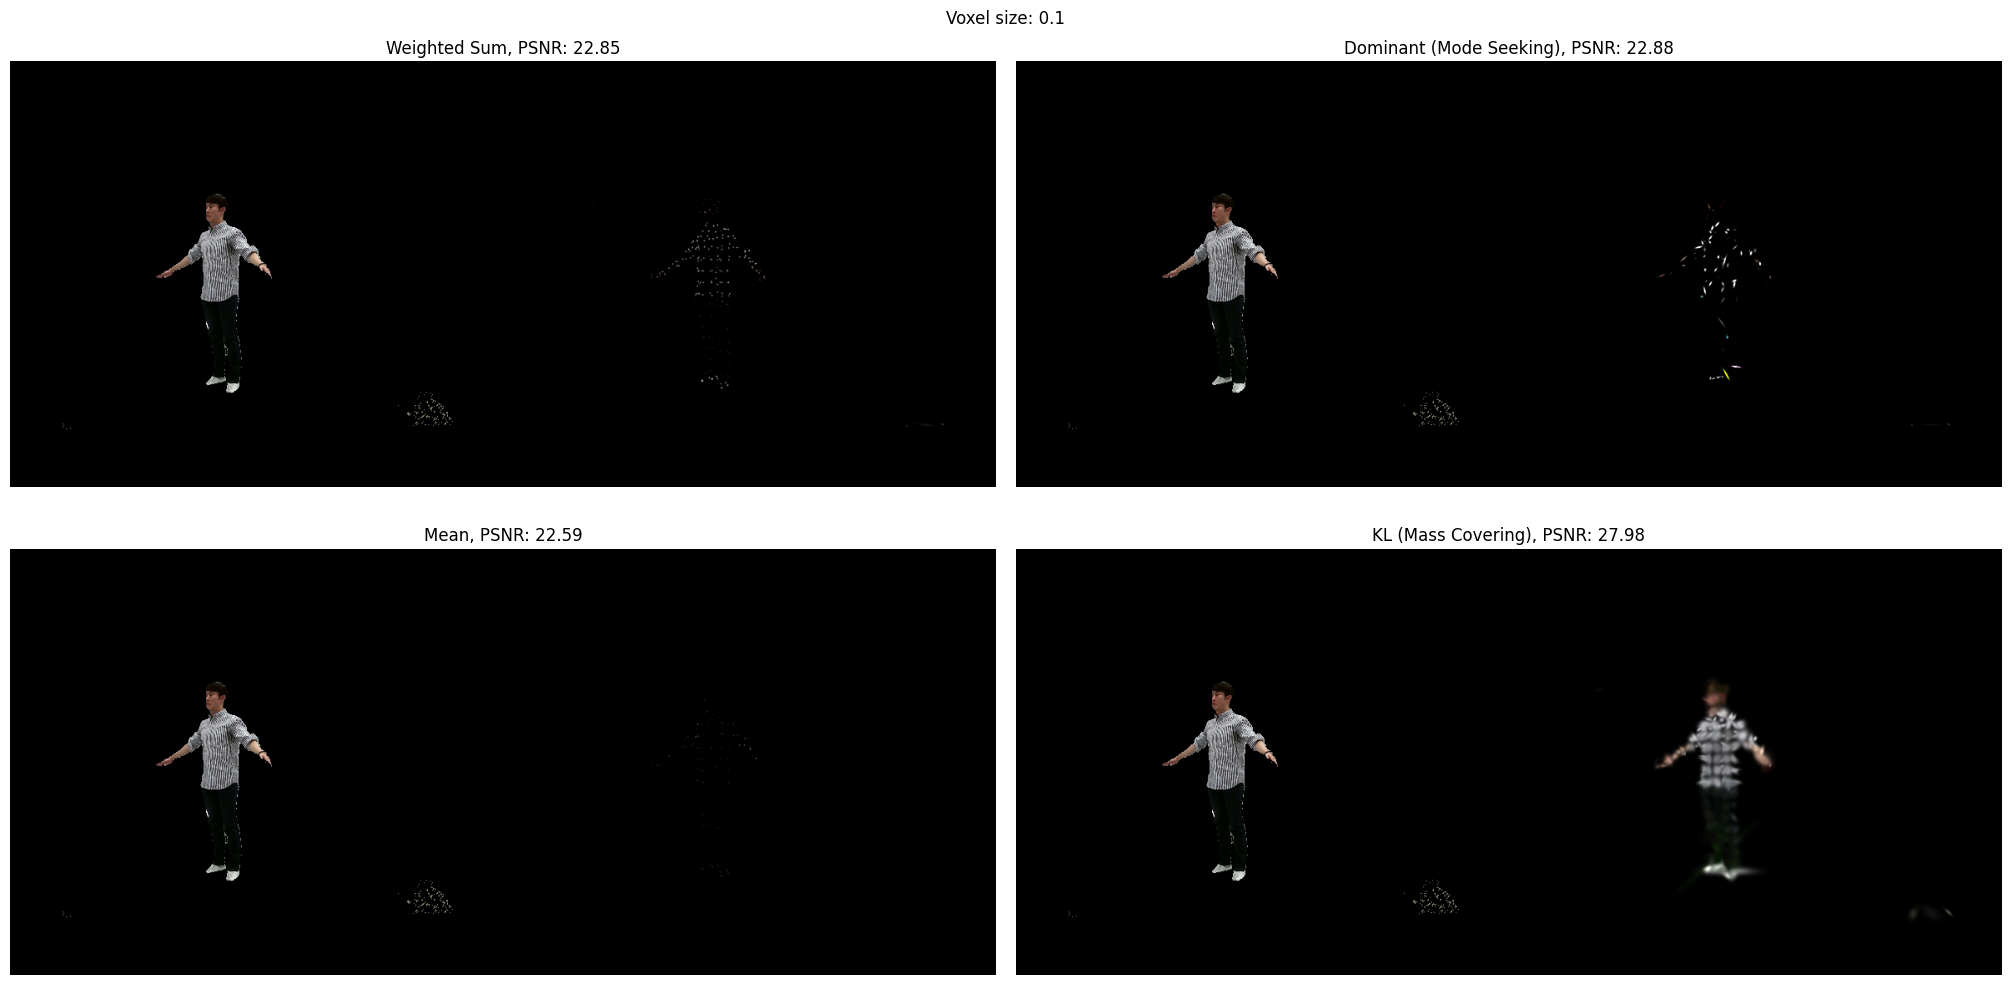

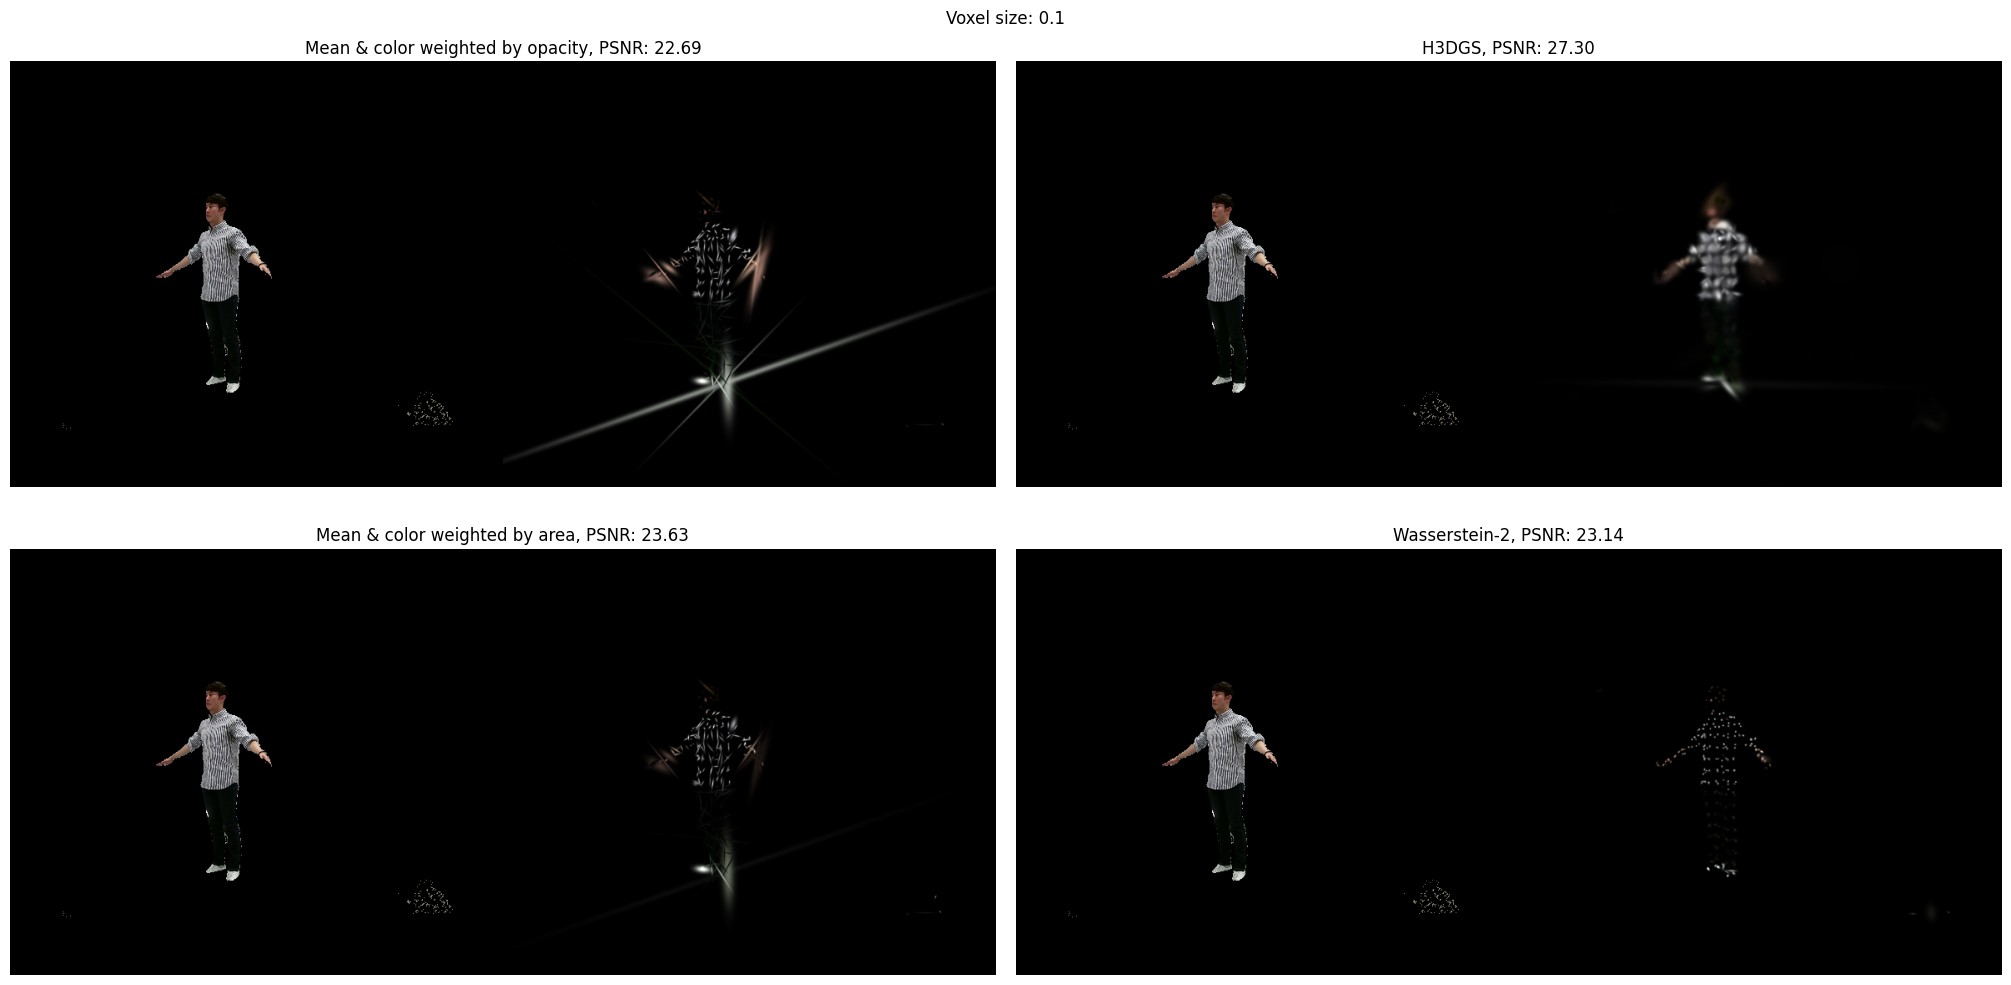

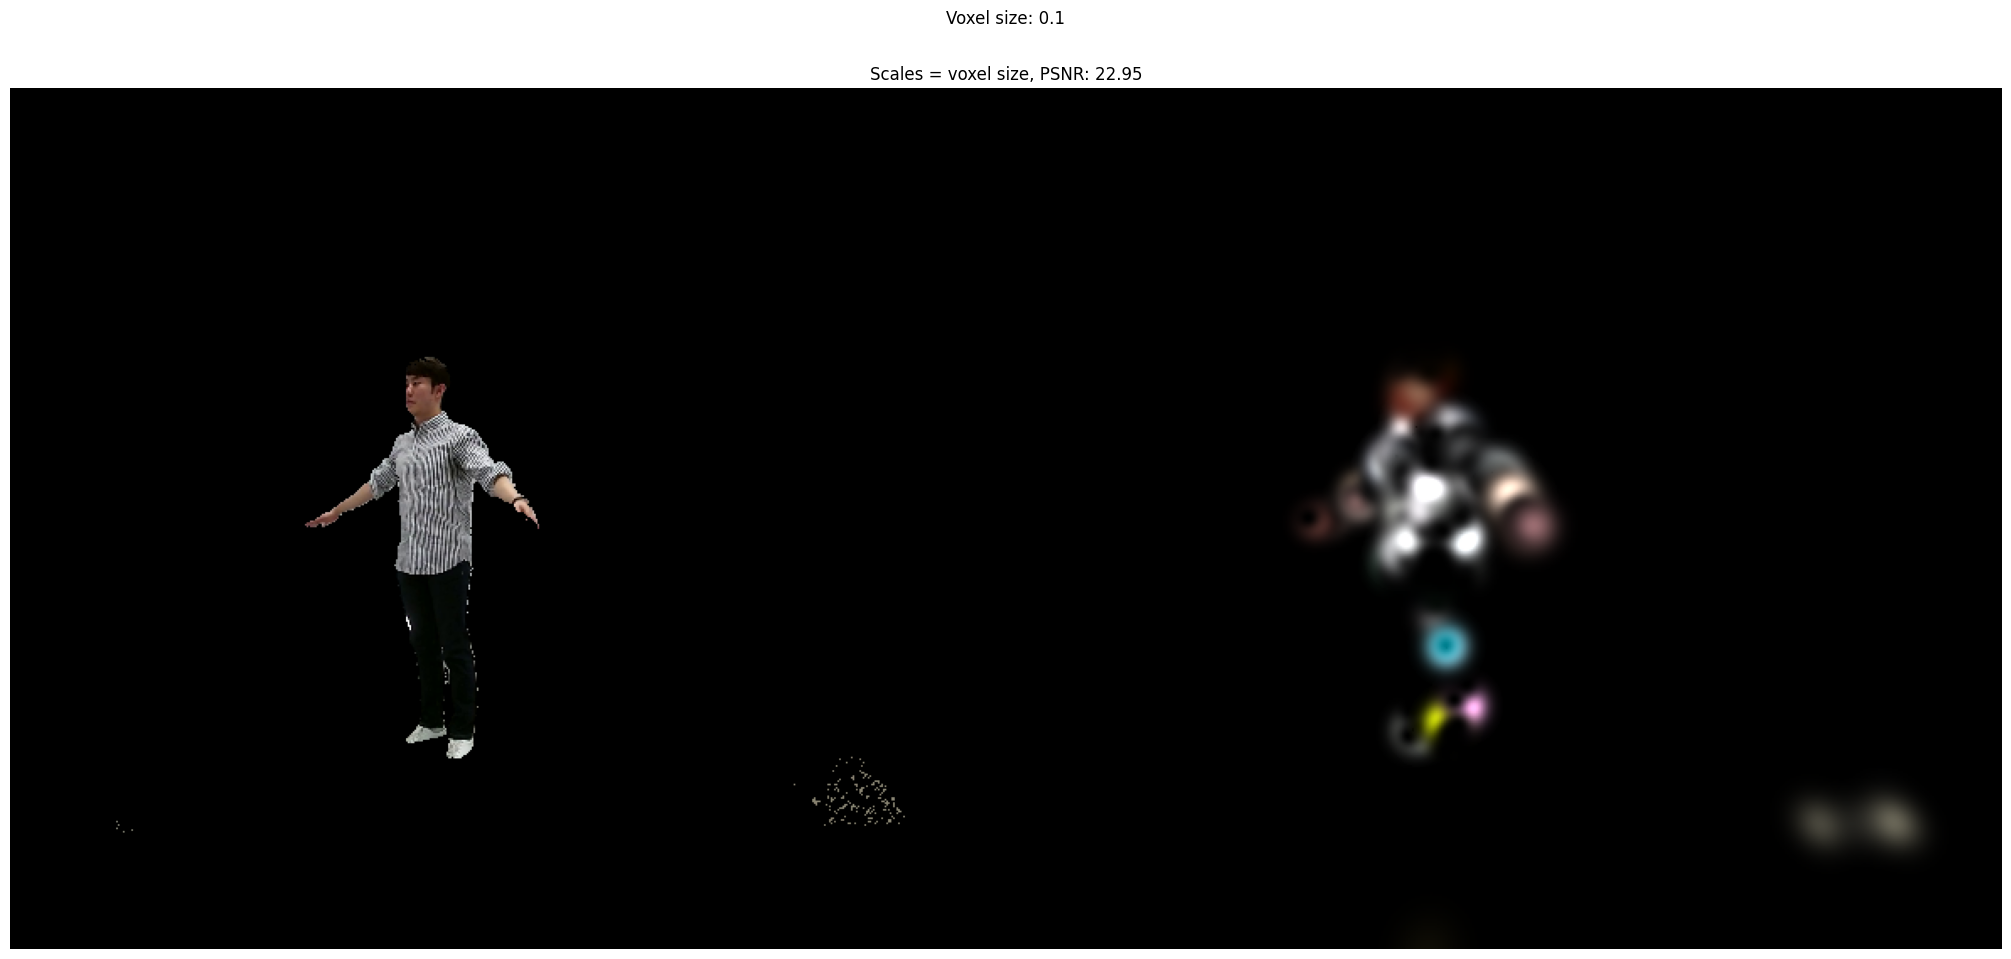

In [13]:
# Create grid of images
exp_names = [
    f"nogop_voxel_size_{trained_voxel_size}_freeze_means_voxelized_to_voxel_size_{voxel_size}"
    for voxel_size in allowable_voxel_sizes
]

# Iterate over the grid of images
for voxel_size, exp_name in zip(allowable_voxel_sizes, exp_names):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)
    for i, (method, method_name) in enumerate(
        zip(aggregate_methods[:4], aggregate_methods_rename[:4])
    ):
        k = i // 2
        j = i % 2
        ax = axes[k, j]
        result_dir = os.path.join(
            data_dir, exp_name, seq_name, f"{frame_id}", f"{method}"
        )

        # Load the image
        image_path = os.path.join(result_dir, "renders", f"val_step0_0000.png")
        image = plt.imread(image_path)

        # Read PSNR, SSIM, LPIPS
        psnr = result_dict[voxel_size][method]["psnr"][0]
        ssim = result_dict[voxel_size][method]["ssim"][0]
        lpips = result_dict[voxel_size][method]["lpips"][0]

        # Display the image
        ax.imshow(image)
        ax.set_title(f"{method_name}, PSNR: {psnr:.2f}")
        ax.axis("off")
    plt.suptitle(f"Voxel size: {voxel_size}")
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)
    for i, (method, method_name) in enumerate(
        zip(aggregate_methods[4:8], aggregate_methods_rename[4:8])
    ):
        k = i // 2
        j = i % 2
        ax = axes[k, j]
        result_dir = os.path.join(
            data_dir, exp_name, seq_name, f"{frame_id}", f"{method}"
        )

        # Load the image
        image_path = os.path.join(result_dir, "renders", f"val_step0_0000.png")
        image = plt.imread(image_path)

        # Read PSNR, SSIM, LPIPS
        psnr = result_dict[voxel_size][method]["psnr"][0]
        ssim = result_dict[voxel_size][method]["ssim"][0]
        lpips = result_dict[voxel_size][method]["lpips"][0]

        # Display the image
        ax.imshow(image)
        ax.set_title(f"{method_name}, PSNR: {psnr:.2f}")
        ax.axis("off")
    plt.suptitle(f"Voxel size: {voxel_size}")
    plt.show()

    fig, axes = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
    for i, (method, method_name) in enumerate(
        zip(aggregate_methods[9:], aggregate_methods_rename[9:])
    ):
        ax = axes
        result_dir = os.path.join(
            data_dir, exp_name, seq_name, f"{frame_id}", f"{method}"
        )

        # Load the image
        image_path = os.path.join(result_dir, "renders", f"val_step0_0000.png")
        image = plt.imread(image_path)

        # Read PSNR, SSIM, LPIPS
        psnr = result_dict[voxel_size][method]["psnr"][0]
        ssim = result_dict[voxel_size][method]["ssim"][0]
        lpips = result_dict[voxel_size][method]["lpips"][0]

        # Display the image
        ax.imshow(image)
        ax.set_title(f"{method_name}, PSNR: {psnr:.2f}")
        ax.axis("off")
    plt.suptitle(f"Voxel size: {voxel_size}")
    plt.show()

In [1]:
import imageio.v2 as imageio
import numpy as np

In [2]:
img = imageio.imread(
    "/ssd1/rajrup/Project/livogs_mv/results/nogop_train_l1_0.5_ssim_0.5_mdepth_0.2_alpha_0.2_mssim_0.2_svar_0.2_ml1_0.2/171026_pose3_no_ground/580/renders/val_step0_0000.png"
)

print(img.shape)

(512, 1184, 3)


In [9]:
import numpy as np

a = np.array([0.0, 1.0, 0.0])
a.shape

# Insert a new axis at position 0
b = np.expand_dims(a, axis=1)
b.shape

(3, 1)